In [2]:
import numpy as np 
import pandas as pd 
from evds import evdsAPI
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings



In [3]:
warnings.filterwarnings("ignore")


In [4]:
evds = evdsAPI("********")

In [5]:
df = evds.get_data(["TP.DK.USD.A.YTL"], startdate="01-01-2020", enddate="20-08-2024", frequency=5)

In [6]:
df['Tarih'] = pd.to_datetime(df['Tarih'])


In [7]:
df.set_index("Tarih", inplace=True)

In [8]:
df.head()

,TP_DK_USD_A_YTL
Tarih,
2020-01-01,5.918159
2020-02-01,6.044470
2020-03-01,6.314432
2020-04-01,6.818952
2020-05-01,6.951947


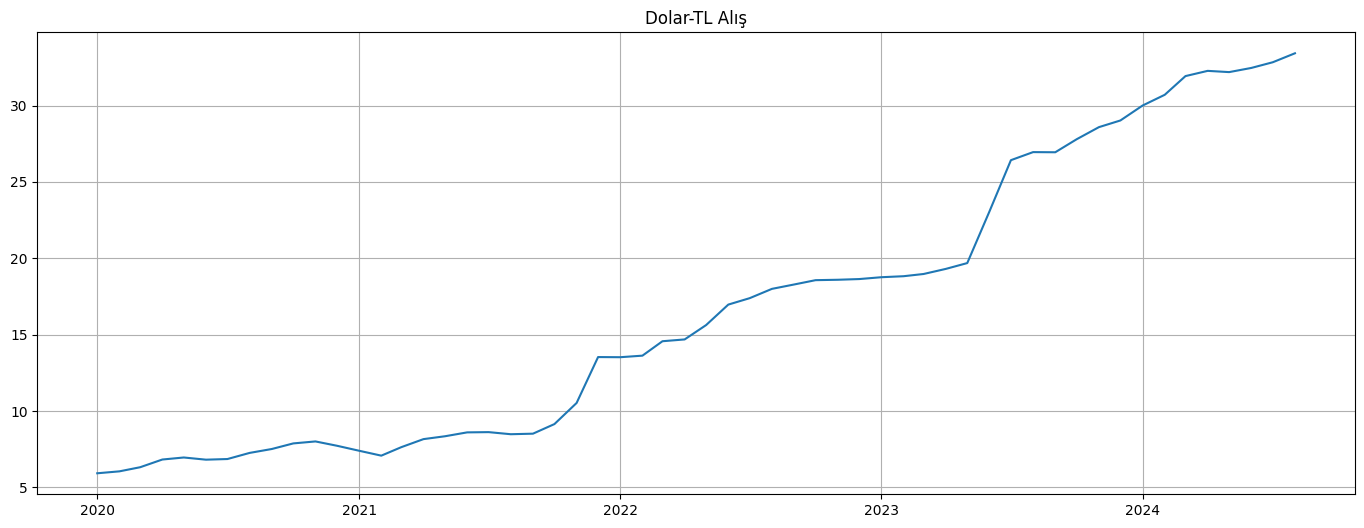

In [9]:
plt.figure(figsize=(17, 6))


plt.plot(df)

plt.title('Dolar-TL Alış')
plt.grid(True)
plt.show()


In [10]:
result = adfuller(df["TP_DK_USD_A_YTL"])

adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print('Critical Values',result[4])


ADF Statistic: 1.0163654062535334
p-value: 0.9944356562479457
Critical Values {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}


In [11]:
df['Differenced_Data'] = df["TP_DK_USD_A_YTL"].diff()
df = df.dropna() 
df.head()

,TP_DK_USD_A_YTL,Differenced_Data
Tarih,,
2020-02-01,6.044470,0.126311
2020-03-01,6.314432,0.269962
2020-04-01,6.818952,0.504521
2020-05-01,6.951947,0.132995
2020-06-01,6.808832,-0.143115


In [12]:
result_differenced = adfuller(df["Differenced_Data"])

adf_statistic = result_differenced[0]
p_value = result_differenced[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print('Critical Values',result_differenced[4])


ADF Statistic: -4.954315686827899
p-value: 2.730837874390158e-05
Critical Values {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}


<Figure size 1400x600 with 0 Axes>

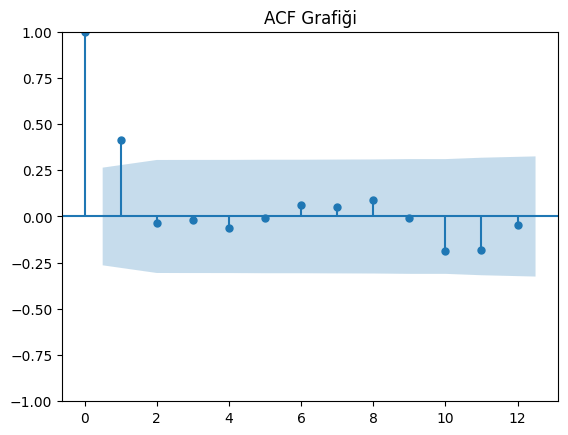

In [13]:
# ACF 
plt.figure(figsize=(14, 6))
plot_acf(df["Differenced_Data"], lags=12)
plt.title('ACF Grafiği')
plt.show()

<Figure size 1200x600 with 0 Axes>

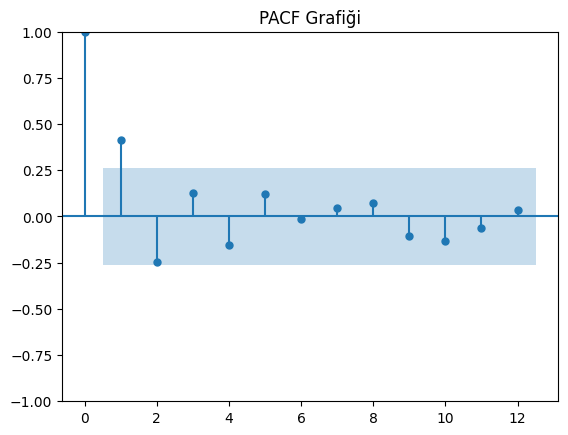

In [14]:
# PACF 
plt.figure(figsize=(12, 6))
plot_pacf(df["Differenced_Data"], lags=12, method='ywm')
plt.title('PACF Grafiği')
plt.show()


In [65]:
split_index = int(0.9 * len(df))
df_train = df["TP_DK_USD_A_YTL"].iloc[:split_index]
df_test = df["TP_DK_USD_A_YTL"].iloc[split_index:]


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools


In [16]:
p = d = q = range(0, 2)  
P = D = Q = range(0, 2)  
S = [12]  

best_aic = float('inf')
best_order = None
best_seasonal_order = None


for param in itertools.product(p, d, q):
    for seasonal_param in itertools.product(P, D, Q):
        try:
            model = SARIMAX(df["TP_DK_USD_A_YTL"], order=param, seasonal_order=seasonal_param + (12,))
            results = model.fit()
            
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue


print(f"En iyi AIC: {best_aic}")
print(f"En iyi ARIMA parametreleri: {best_order}")
print(f"En iyi mevsimsel parametreler: {best_seasonal_order}")


En iyi AIC: 112.47701530464535
En iyi ARIMA parametreleri: (0, 1, 1)
En iyi mevsimsel parametreler: (0, 1, 1)


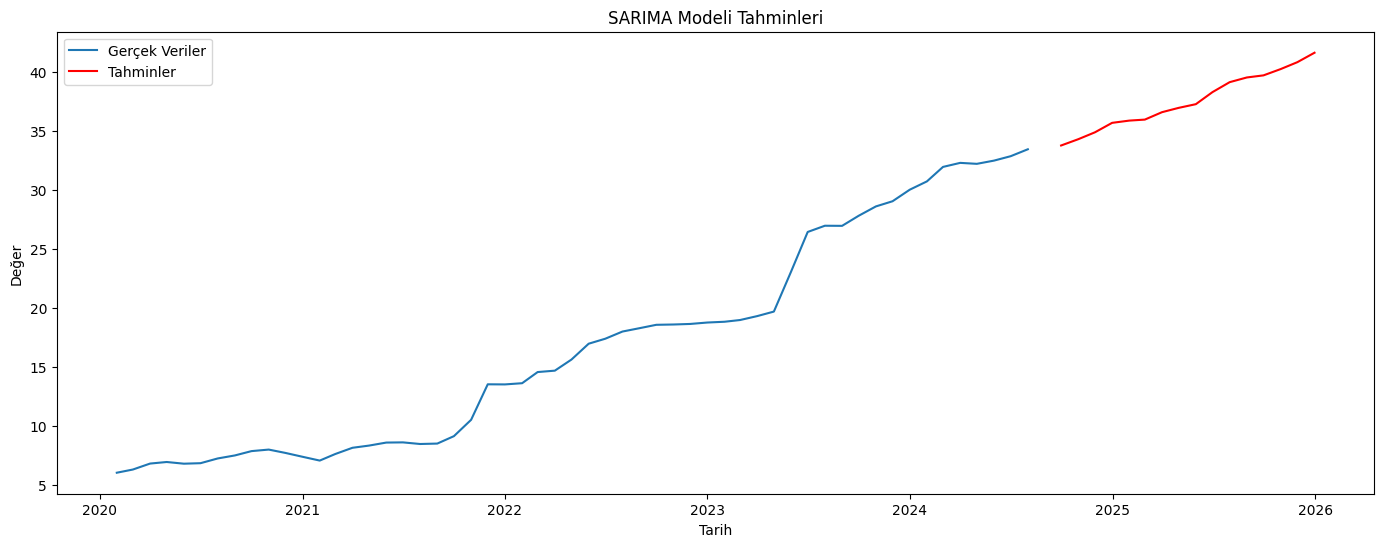

In [20]:
model = SARIMAX(df["TP_DK_USD_A_YTL"], order=best_order, seasonal_order=best_seasonal_order + (12,))
results = model.fit()

# Tahmin 
forecast = results.get_forecast(steps=16)  
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=16, freq='M')
forecast_values = forecast.predicted_mean


plt.figure(figsize=(17, 6))
plt.plot(df.index, df["TP_DK_USD_A_YTL"], label='Gerçek Veriler')
plt.plot(forecast_index, forecast_values, label='Tahminler', color='red')
plt.title('SARIMA Modeli Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Değer')
plt.legend()
plt.show()


In [21]:
forecast_values

2024-09-01    33.742510
2024-10-01    34.275618
2024-11-01    34.857769
2024-12-01    35.659264
2025-01-01    35.849639
2025-02-01    35.934254
2025-03-01    36.562545
2025-04-01    36.927405
2025-05-01    37.239586
2025-06-01    38.260693
2025-07-01    39.103135
2025-08-01    39.500521
2025-09-01    39.678157
2025-10-01    40.211266
2025-11-01    40.793417
2025-12-01    41.594911
Freq: MS, Name: predicted_mean, dtype: float64